# Import the libarary

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# load data 

In [3]:
df = pd.read_csv("../data/laptop_final.csv")
df.keys()

FileNotFoundError: [Errno 2] No such file or directory: '../data/laptop_final.csv'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


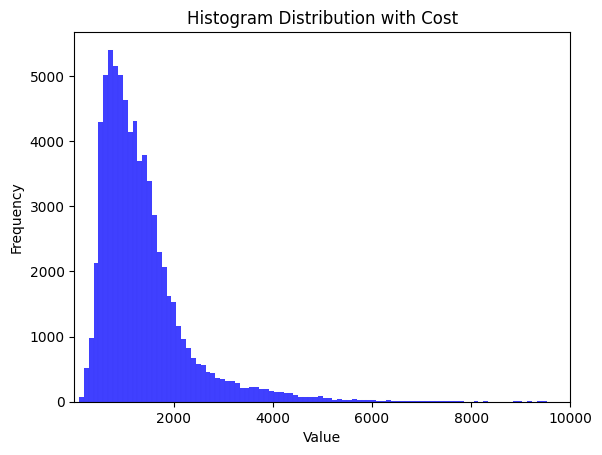

In [98]:
# cost distribution 
sns.histplot(df['Cost'], bins=10000, color='blue')

plt.title("Histogram Distribution with Cost")
plt.xlabel("Value")
plt.xlim(1,10000)
plt.ylabel("Frequency")

plt.show()


In [3]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df_1=df.drop(columns=["link","GPU: Name","CPU: Name","Ethernet LAN"])
df_2 = df_1.drop_duplicates()

### Drop nan values

In [100]:
df_2.isnull().sum()

name                                            0
Display Size                                    0
Resolution: width                               0
Resolution: height                              0
Refresh Rate                                    0
Panel Type                                      0
Disk Capacity                                   0
SSD                                             0
HDD                                             0
SSHD                                            0
Optane                                          0
RAM Capacity                                  291
RAM Type                                    31654
OS                                            677
Body material: plastic / polycarbonate          0
Body material: aluminum                         0
Body material: magnesium alloy                  0
Body material: glass fiber                      0
Body material: carbon                           0
Body material: magnesium-lithium alloy          0


In [101]:
df_3 = df_2.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is: {} and after drop nan values is: {}".format(df.shape[0], df_3.shape[0]))

The number of data points before drop nan is: 289171 and after drop nan values is: 35237


### Add more features following our knowledge about laptop architecture

* Features creating base on general features


In [102]:
body_features = ['Body material: plastic / polycarbonate', 'Body material: aluminum',
       'Body material: magnesium alloy', 'Body material: glass fiber',
       'Body material: carbon', 'Body material: magnesium-lithium alloy',
       'Body material: plastic', 'Body material: matte',
       'Body material: black synthetic material']
Connectivity_features = ['USB Type-C', 'USB Type-A', 'HDMI', 'Card Reader']
outside_memory = ['Disk Capacity','SSD','HDD','SSHD']


In [103]:
# Add the connectivity score that is the sum of connection gate availability in laptop
df_3['Connectivity Score'] = df_3[Connectivity_features].sum(axis=1)
                                                                    
# Add the Lightweight Build for specific low-weighted materials.
threshold_weight = 2.0                                        
df_3['Lightweight Build'] = df_3.apply(lambda x: 1 if any(mat in x for mat in body_features) and x['Weight'] < threshold_weight else 0, axis=1)
print(df_3['Lightweight Build'].value_counts()) 

# Add the outside memory score as sum of the type of outside memory
df_3['Outside Memory Score'] = df_3[outside_memory].sum(axis=1)

/tmp/ipykernel_24/88215552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Connectivity Score'] = df_3[Connectivity_features].sum(axis=1)


Lightweight Build
1    19586
0    15651
Name: count, dtype: int64


/tmp/ipykernel_24/88215552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Lightweight Build'] = df_3.apply(lambda x: 1 if any(mat in x for mat in body_features) and x['Weight'] < threshold_weight else 0, axis=1)
/tmp/ipykernel_24/88215552.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['Outside Memory Score'] = df_3[outside_memory].sum(axis=1)


* Features creating by our knowledge


+ **CPU Processing Power** (Ghz)= CPU: Core x CPU: Base Frequency
   
      - CPU: Core is the number of core in CPU 
      - CPU: Base Frequency is the speed where each core operates (GHz)
  
  ⇒ This feature tells the total number of cycles the CPU can operate in a second (Ghz)

+ **GPU Band Width** (bits/s) = GPU: Memory Frequency × GPU: Memory Bus 
  
      - GPU: Memory Frequency is the clock speed of GPU memory (Mhz)
      - GPU: Memory Bus is the number of bits the memory can transfer per clock cycle (bits/cycle)
  
  ⇒ Represent how fast data can move between the GPU memory and the GPU’s cores for processing (bits/s)

+ **GPU Efficiency** (cycles/J) = GPU: Base Clock / GPU: Power Consumption

      -GPU: Base Clock is the clock speed of GPU core (Ghz)
      -GPU: Power Consumption is the power GPU uses during operation (W)

  ⇒ Represent how much work GPU can do per unit of energy consumption (cycles/J)

In [104]:
df_3["CPU: Processing Power"]=df_3["CPU: Core"]*df_3["CPU: Base frequency"]
df_3["GPU: Band Width"]=df_3["GPU: Memory Frequency (MHz)"]*df_3["GPU: Memory Bus"]
df_3["GPU: Efficiency"]=df_3["GPU: Base Clock"]/df_3["GPU: Power Consumption"]

/tmp/ipykernel_24/715019289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["CPU: Processing Power"]=df_3["CPU: Core"]*df_3["CPU: Base frequency"]
/tmp/ipykernel_24/715019289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3["GPU: Band Width"]=df_3["GPU: Memory Frequency (MHz)"]*df_3["GPU: Memory Bus"]
/tmp/ipykernel_24/715019289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

* Model of each brand laptop

In [105]:

df_3['name'].str.split().str[1].str.lower().unique()


array(['rog', 'legion', 'raider', 'titan', 'proart', 'vivobook', 'm16',
       '17x', 'm18', 'vector', 'blade', 'precision', 'zbook', 'thinkpad',
       'g16', 'omen', 'g15', 'predator', '16x', 'victus', 'nitro', 'tuf',
       'cyborg', 'loq', 'x16', 'stealth', 'pulse', 'xps', 'zenbook',
       'galaxy', 'katana', 'aero', '2023', 'surface', 'bravo', 'x15',
       'x17', 'ideapad', 'envy', 'spectre', 'inspiron', 'swift',
       'commercial', 'prestige', '15', '17', '16', 'thinkbook', 'yoga',
       'creator', 'g6', 'g5', 'crosshair', 'pavilion', 'm17', 'ge76',
       'ge66', 'latitude', 'sword', 'thin', 'aspire', 'elitebook', 'm15',
       'delta', 'v15', 'ws66', 'ws76', 'gram', 'summit', 'travelmate',
       'chromebook', 'slim', '2022', 'expertbook', 'probook', 'vostro',
       'elite', '470', '14', 'flex', 'gs66', 'gp66', 'gf63', 'modern',
       'v14', 'gf65', 'dragonfly', '17-cn200', '250', 'flex5', 'spin',
       'e13', 'toughbook', 'pro', 'gl65', 'g3', 'gf75', '500e', '14e',
    

In [106]:
df_3['model'] = df_3['name'].str.split().str[1].str.lower()
df_3 = df_3.drop(columns =['name'] )

/tmp/ipykernel_24/3391172191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['model'] = df_3['name'].str.split().str[1].str.lower()


### Train test split to target encoding 
  

In [107]:
target="Cost"
X=df_3.drop(columns=[target])
y=df_3[target]

In [108]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=64)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type",'CPU: Codename','model']

In [109]:
print(X_train.shape[0])
print(y_train.shape[0])

28189
28189


In [110]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df_3[col].nunique())

Number of unique values in Panel Type:  10
Number of unique values in RAM Type:  2
Number of unique values in OS:  8
Number of unique values in GPU: Architecture:  28
Number of unique values in GPU: Memory Type:  3
Number of unique values in CPU: Codename:  28
Number of unique values in model:  114


In [111]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
# Transform this encoder in X_test
X_test=encoder.transform(X_test)

### Features Selection

In [112]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption","CPU: Processing Power",
                   "GPU: Band Width","GPU: Efficiency","Connectivity Score","Outside Memory Score",
                   "Portability Score","Display Score","Work Score","Play Score",'Total Score']
categorical_features=list(set(df_3.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Backlit keyboard', 'RAM Type', 'Body material: matte', 'Panel Type', 'Body material: magnesium alloy', 'model', 'Body material: aluminum', 'Lightweight Build', 'GPU: Memory Type', 'Fingerprint reader', 'Optane', 'CPU: Codename', 'SSHD', 'HDD', 'Body material: magnesium-lithium alloy', 'Body material: plastic', 'Body material: black synthetic material', 'Card Reader', 'Body material: glass fiber', 'GPU: Architecture', 'OS', 'Body material: carbon', 'SSD', 'Security Lock slot', 'Body material: plastic / polycarbonate']
25


* Normalization for features selection.

In [113]:
normalized_X_train = X_train.copy()
normalized_X_train[numerical_features]=(X_train[numerical_features] - X_train[numerical_features].mean())/X_train[numerical_features].std()
normalized_X_train.head(5)

Display Size  Resolution: width  Resolution: height  Refresh Rate  \
209838     -0.113384          -0.272838           -0.352482     -0.673822   
186290     -0.113384          -0.272838           -0.352482     -0.673822   
241300      0.299013          -0.272838            0.092388     -0.673822   
187644     -0.113384          -0.272838           -0.352482     -0.673822   
57385      -0.113384          -0.272838           -0.352482     -0.673822   

         Panel Type  Disk Capacity  SSD  HDD  SSHD  Optane  ...  \
209838  1433.636806      -0.347551  1.0  0.0   0.0     0.0  ...   
186290  1433.636806      -0.687014  1.0  0.0   0.0     0.0  ...   
241300  1433.636806      -0.570210  1.0  0.0   0.0     0.0  ...   
187644  1433.636806      -0.570210  1.0  0.0   0.0     0.0  ...   
57385   1433.636806      -0.570210  1.0  0.0   0.0     0.0  ...   

        GPU: Memory Bus  GPU: Release quarter  GPU: Power Consumption  \
209838        -0.802625             -0.632397               -0.849126   
186290        -0.802625             -0.632397               -0.849126   
241300         0.693058              0.152825                0.771574   
187644        -0.802625             -0.632397               -0.849126   
57385         -0.802625             -0.632397               -0.849126   

        Connectivity Score  Lightweight Build  Outside Memory Score  \
209838            0.205388                  1             -0.347562   
186290           -0.673621                  1             -0.687025   
241300            1.172297                  1             -0.570221   
187644           -0.322017                  1             -0.570221   
57385            -0.585720                  1             -0.570221   

        CPU: Processing Power  GPU: Band Width  GPU: Efficiency        model  
209838              -0.730239        -0.430234         0.334907  1144.225453  
186290              -0.873787        -0.430234         0.334907  1318.727103  
241300               1.153829        -0.195496        -0.495727  1513.124820  
187644              -0.873787        -0.430234         0.334907   882.868762  
57385                0.633467        -0.430234         0.334907  1144.225453  

[5 rows x 63 columns]

* Multual Information and Anova for feature selection with Catgorical

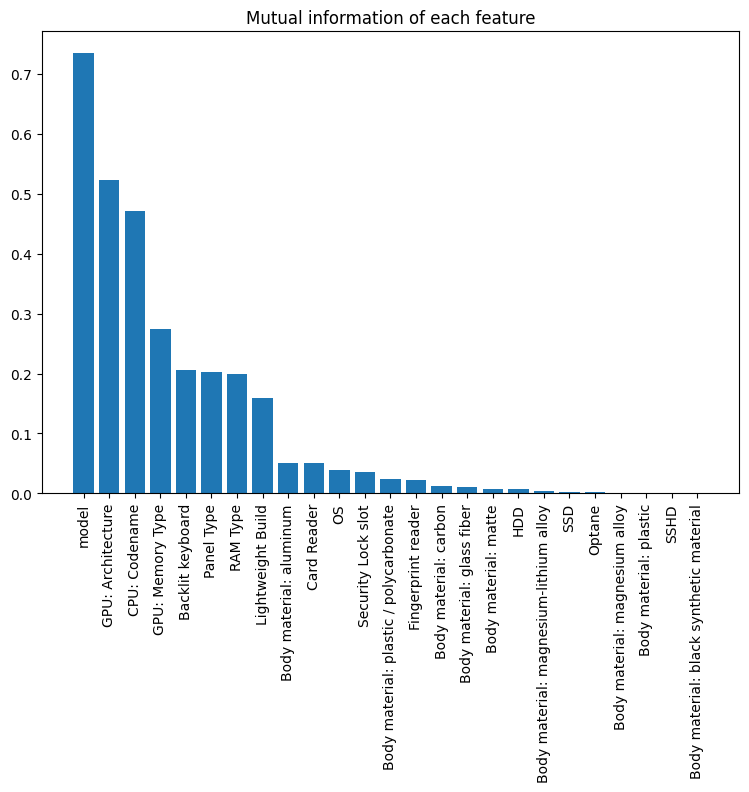

In [114]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(normalized_X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 2 10 12 15 16 22] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


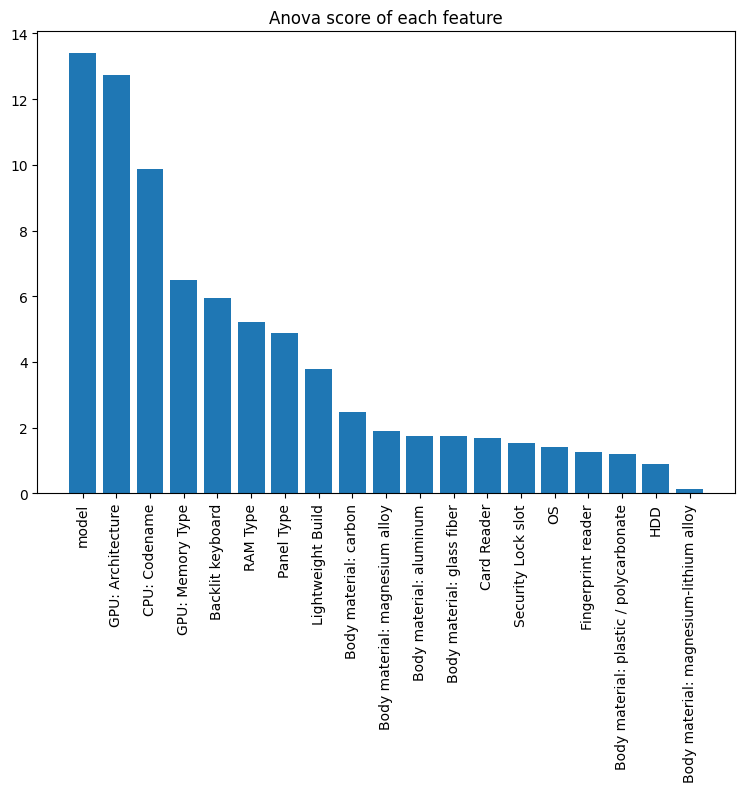

In [115]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(normalized_X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

* Using pearson, spearman correlation to find the most relevant in numerical features

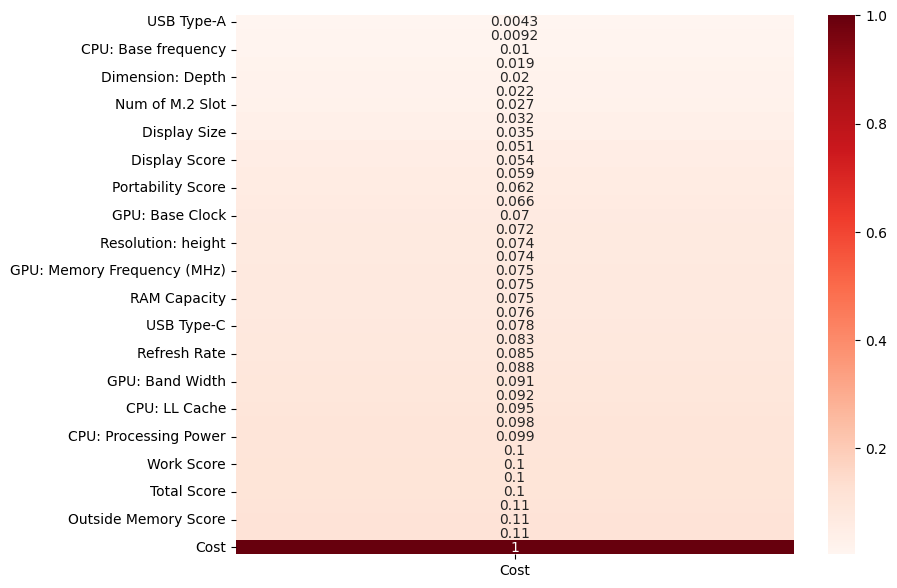

In [116]:
# using pearson score
train_set=normalized_X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

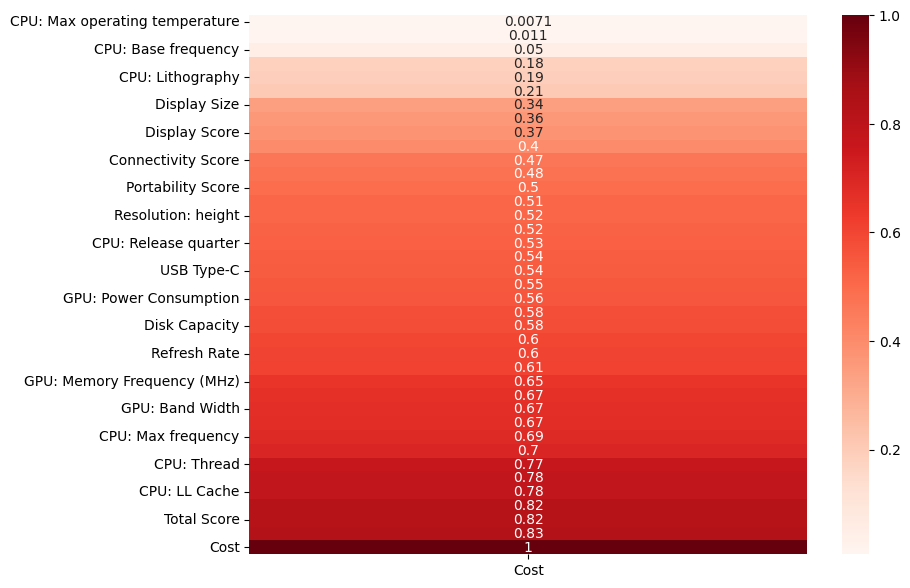

In [117]:
# using spearman score
train_set=normalized_X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.abs().sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

In [118]:
# Choose candidate features in 2 groups
candidate_num_features = target_correlation[target].abs().sort_values(ascending=False).index[1:6].tolist()
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['model', 'GPU: Architecture', 'CPU: Codename', 'GPU: Memory Type', 'Backlit keyboard', 'Play Score', 'Total Score', 'Work Score', 'CPU: LL Cache', 'CPU: Processing Power']


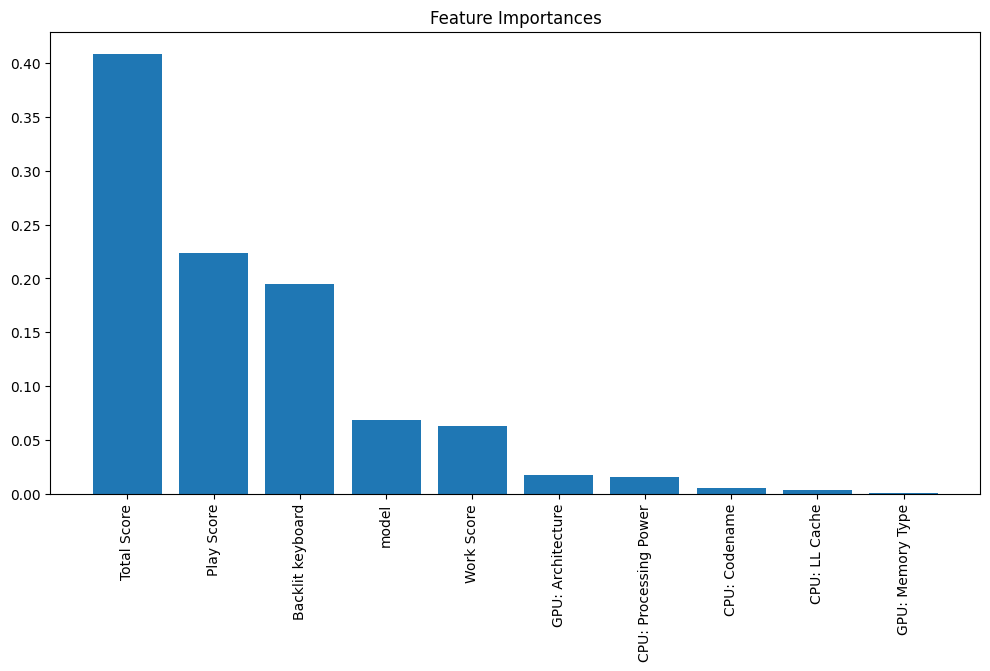

In [119]:
candidate_X = X_train[candidate_featues] 
model = RandomForestRegressor()
model.fit(candidate_X, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [4]:
final_features = ["GPU: Architecture","Play Score","Work Score",'Total Score',"CPU: LL Cache",
                  'Disk Capacity','RAM Capacity','CPU: Codename','model','RAM Type',
                 'GPU: Memory Frequency (MHz)', 'GPU: Power Consumption', 'CPU: Max frequency']

* features engineering again to drop nan with selection features

In [5]:
df_2.shape

(197088, 58)

In [6]:
# outside memory features
outside_memory = ['Disk Capacity','SSD','HDD','SSHD']
df_2['Outside Memory Score'] = df_2[outside_memory].sum(axis=1)
# model catgorical features
df_2['model'] = df_2['name'].str.split().str[1].str.lower()
df_2 = df_2.drop(columns =['name'])
#CPU processing power
df_2["CPU: Processing Power"]=df_2["CPU: Core"]*df_2["CPU: Base frequency"]

/tmp/ipykernel_24/2358445073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Outside Memory Score'] = df_2[outside_memory].sum(axis=1)
/tmp/ipykernel_24/2358445073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['model'] = df_2['name'].str.split().str[1].str.lower()


In [7]:
df_final = df_2[final_features + ['Cost']]

In [8]:
df_final_1 = df_final.dropna()

In [9]:
df_final_1

GPU: Architecture  Play Score  Work Score  Total Score  CPU: LL Cache  \
0           Ada Lovelace         8.3         9.2          8.2        65536.0   
4           Ada Lovelace         8.2         8.8          8.1        65536.0   
8           Ada Lovelace         9.6         9.4          8.6        65536.0   
9           Ada Lovelace         9.6         9.2          8.5        65536.0   
12          Ada Lovelace         9.6         9.2          8.5        65536.0   
...                  ...         ...         ...          ...            ...   
288668          Ice Lake         1.8         4.8          4.8         6144.0   
288712    Tiger Lake GT2         1.6         4.2          3.3         6144.0   
288731          Ice Lake         1.8         4.6          4.8         6144.0   
288997          Ice Lake         1.6         4.0          4.5         6144.0   
289105    Tiger Lake GT2         1.6         4.4          3.4         6144.0   

        Disk Capacity  RAM Capacity CPU: Codename model RAM Type  \
0              2000.0          64.0  Dragon Range   rog     DDR5   
4              2000.0          16.0  Dragon Range   rog     DDR5   
8              8000.0          64.0  Dragon Range   rog     DDR5   
9              8000.0          32.0  Dragon Range   rog     DDR5   
12             1000.0          32.0  Dragon Range   rog     DDR5   
...               ...           ...           ...   ...      ...   
288668         3000.0          32.0  Tiger Lake-U    17     DDR4   
288712         1256.0          16.0  Tiger Lake-U    17     DDR4   
288731         3000.0          16.0  Tiger Lake-U    17     DDR4   
288997         1512.0           8.0  Tiger Lake-U    17     DDR4   
289105          512.0          32.0  Tiger Lake-U    17     DDR4   

        GPU: Memory Frequency (MHz)  GPU: Power Consumption  \
0                            2000.0                   140.0   
4                            2000.0                   140.0   
8                           20000.0                   175.0   
9                           20000.0                   175.0   
12                          20000.0                   175.0   
...                             ...                     ...   
288668                          0.0                    45.0   
288712                          0.0                    15.0   
288731                          0.0                    45.0   
288997                          0.0                    45.0   
289105                          0.0                    15.0   

        CPU: Max frequency     Cost  
0                   5400.0  2249.00  
4                   5400.0  2138.99  
8                   5400.0  3769.00  
9                   5400.0  4658.99  
12                  5400.0  3224.01  
...                    ...      ...  
288668              4100.0   909.00  
288712              4100.0   659.00  
288731              4100.0   849.00  
288997              4100.0   629.00  
289105              4100.0   599.00  

[39025 rows x 14 columns]

* target encoder again

In [10]:
cost = df_final_1[['Cost', 'Total Score']].astype(float)
insane_cost = cost[cost['Cost'] > 7000]
outliers_1 = insane_cost[insane_cost['Cost'] > 10000]
outliers_2 = insane_cost[insane_cost['Total Score'] < 7.0]
outliers = pd.concat([outliers_1, outliers_2])
df_final_1 = df_final_1.drop(outliers.index)

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_final_1['model'] = le.fit_transform(df_final_1['model'])
df_final_1['CPU: Codename'] = le.fit_transform(df_final_1['CPU: Codename'])
df_final_1['GPU: Architecture'] = le.fit_transform(df_final_1['GPU: Architecture'])
df_final_1['RAM Type'] = le.fit_transform(df_final_1['RAM Type'])

In [12]:
target="Cost"
X=df_final_1.drop(columns=[target])
y=df_final_1[target]


In [13]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=64)

### removal outlier

In [242]:
chooses_num_features = ["Play Score","Work Score",'Total Score',"CPU: LL Cache",
                  'Disk Capacity','RAM Capacity','CPU: Codename','model',
                 'GPU: Memory Frequency (MHz)', 'GPU: Power Consumption', 'CPU: Max frequency']
chooses_cat_features = ["GPU: Architecture",'model','CPU: Codename','RAM Type']

* visualize boxplot 

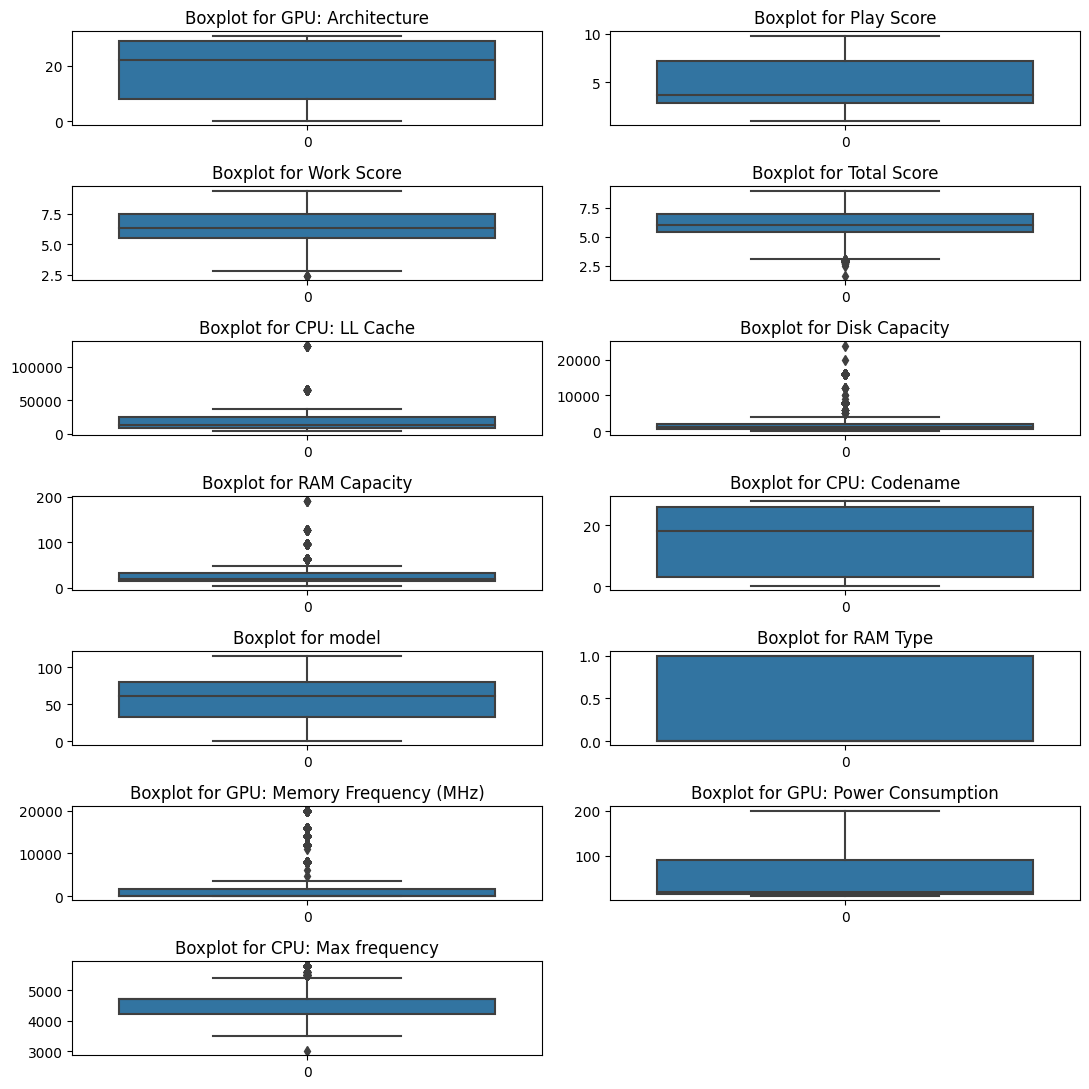

In [243]:
plt.figure(figsize=(11,11))
for i,var in enumerate(final_features):
  plt.subplot(7,2,i+1) 
  sns.boxplot(X_train[var])
  plt.title(f'Boxplot for {var}')
plt.tight_layout()
plt.show()

* Numerical Features

Using IQR (Interquartle Range) and MAD (median absolute deviation) for asymmetric data  in Numerical Features

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

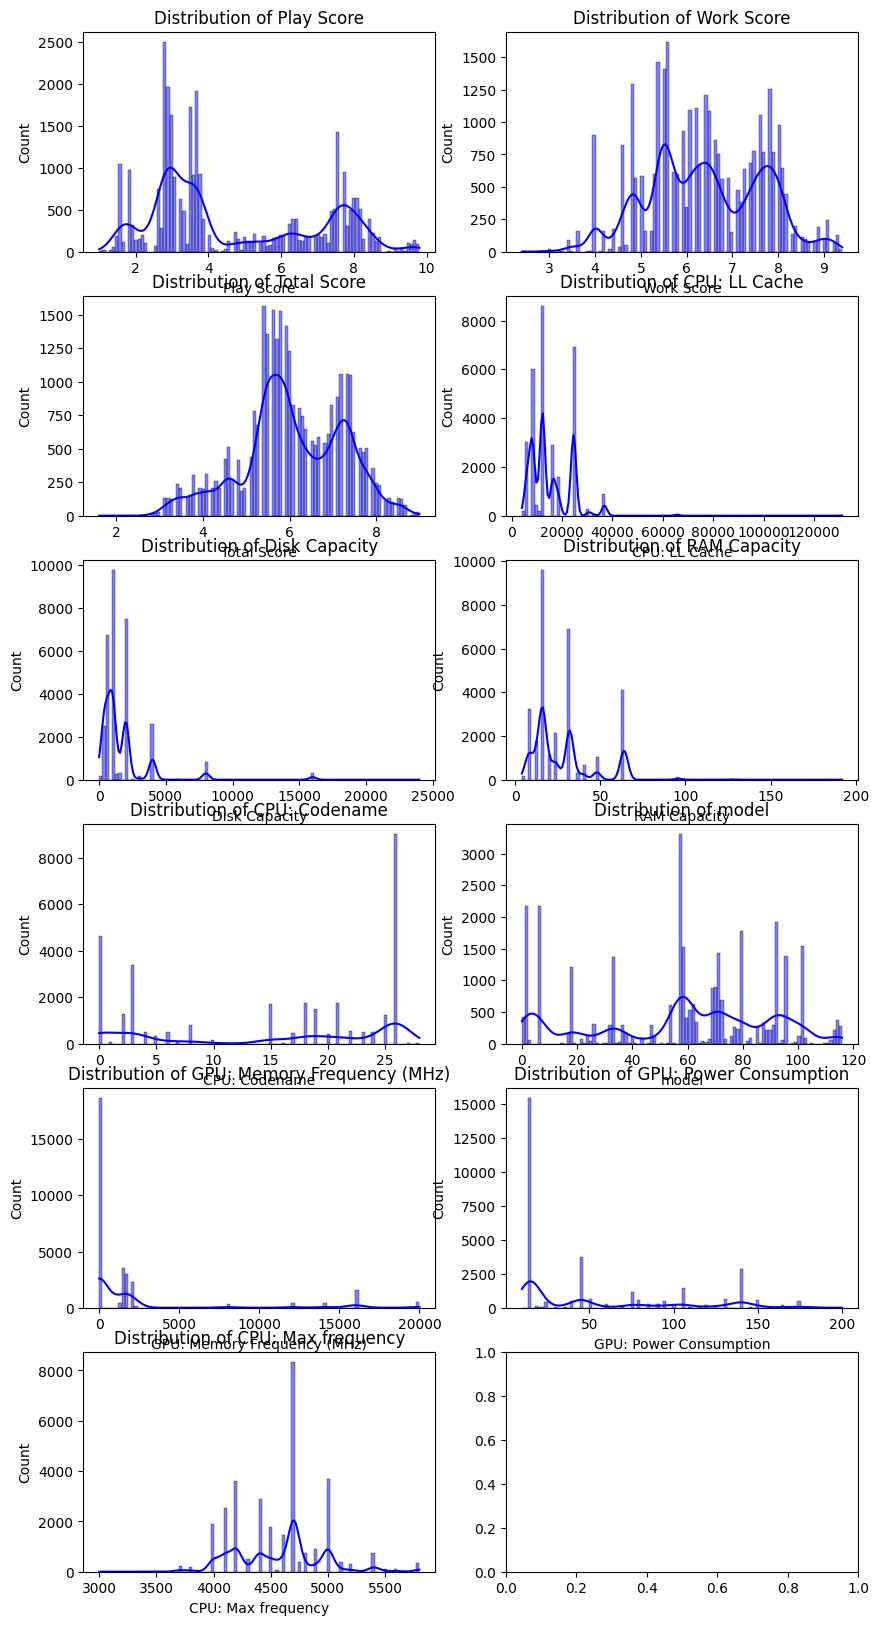

In [245]:
# distribution of of all final features 
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 20))
axes = axes.flatten() 
for i, column in enumerate(chooses_num_features):
    ax = axes[i]
    sns.histplot(X_train[column], kde=True, bins=100, color='blue', ax= ax)
    ax.set_title(f'Distribution of {column}')
    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

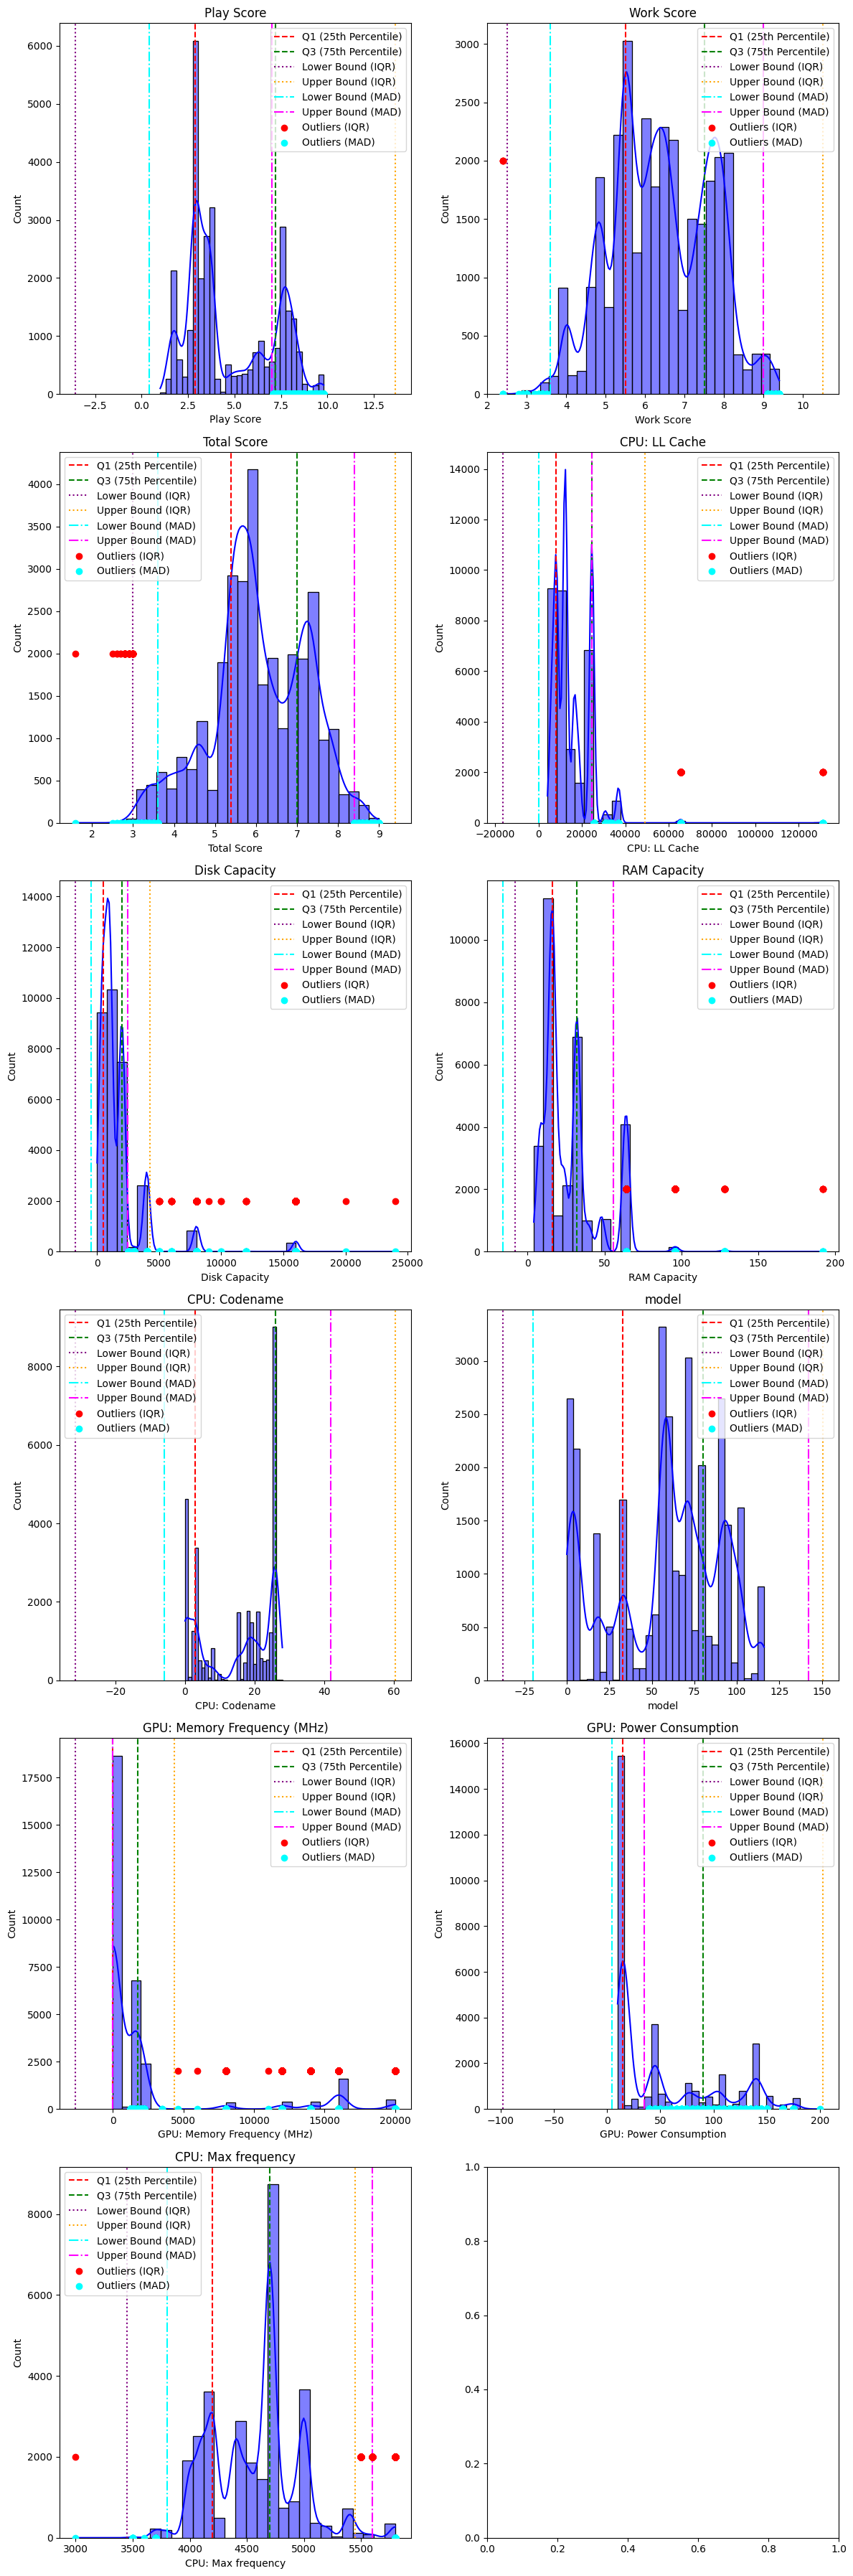

In [246]:
# Suppose the removal of outlier based on IQR and MAD
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def detect_outliers(data):
    # IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound_iqr = Q1 - 1.5 * IQR
    upper_bound_iqr = Q3 + 1.5 * IQR
    # MAD
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    lower_bound_mad = median - 3 * mad
    upper_bound_mad = median + 3 * mad
    return Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad
def plot_distribution(data, ax, title, bin = 30):
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(data)
    sns.histplot(data, kde=True, bins=bin, color='blue', ax=ax)
    ax.axvline(Q1, color="red", linestyle="--", label="Q1 (25th Percentile)")
    ax.axvline(Q3, color="green", linestyle="--", label="Q3 (75th Percentile)")

    ax.axvline(lower_bound_iqr, color="purple", linestyle=":", label="Lower Bound (IQR)")
    ax.axvline(upper_bound_iqr, color="orange", linestyle=":", label="Upper Bound (IQR)")
    ax.axvline(lower_bound_mad, color="cyan", linestyle="-.", label="Lower Bound (MAD)")
    ax.axvline(upper_bound_mad, color="magenta", linestyle="-.", label="Upper Bound (MAD)")

    iqr_outliers = data[(data < lower_bound_iqr) | (data > upper_bound_iqr)]
    mad_outliers = data[(data < lower_bound_mad) | (data > upper_bound_mad)]
    ax.scatter(iqr_outliers, [2000] * len(iqr_outliers), color="red", label="Outliers (IQR)", zorder=5)
    ax.scatter(mad_outliers, [0] * len(mad_outliers), color="cyan", label="Outliers (MAD)", zorder=5)
    ax.set_title(title)
    ax.legend()
n_features = len(chooses_num_features)
n_cols = 2  
n_rows = (n_features + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()  
for i in range(n_features):
    plot_distribution(X_train[chooses_num_features[i]], axes[i], chooses_num_features[i])
plt.tight_layout()
plt.show()

In [247]:
for feat in chooses_num_features:
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train[feat])
    outliers_iqr = X_train[(X_train[feat] < lower_bound_iqr) | (X_train[feat]> upper_bound_iqr)]
    print("Number of outlier based on IQR technique in feature "+ feat+": "+"{}".format(len(outliers_iqr)))
    outliers_mad = X_train[(X_train[feat] < lower_bound_mad) | (X_train[feat]> upper_bound_mad)]
    print("Number of outlier based on MAD technique in feature "+ feat+": "+"{}".format(len(outliers_mad)))

Number of outlier based on IQR technique in feature Play Score: 0
Number of outlier based on MAD technique in feature Play Score: 8049
Number of outlier based on IQR technique in feature Work Score: 3
Number of outlier based on MAD technique in feature Work Score: 598
Number of outlier based on IQR technique in feature Total Score: 78
Number of outlier based on MAD technique in feature Total Score: 1558
Number of outlier based on IQR technique in feature CPU: LL Cache: 95
Number of outlier based on MAD technique in feature CPU: LL Cache: 1392
Number of outlier based on IQR technique in feature Disk Capacity: 1196
Number of outlier based on MAD technique in feature Disk Capacity: 3968
Number of outlier based on IQR technique in feature RAM Capacity: 4274
Number of outlier based on MAD technique in feature RAM Capacity: 4274
Number of outlier based on IQR technique in feature CPU: Codename: 0
Number of outlier based on MAD technique in feature CPU: Codename: 0
Number of outlier based on 

In [14]:
#Removal of outliers in weight using IQR technique and GPU Architecture using MAD technique.
iqr_remove = ["Play Score","Work Score",'Total Score']
mad_remove = ['CPU: Max frequency']
reduced_X_train = X_train.copy() 
for feat in iqr_remove:  
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train[feat])
    reduced_X_train = reduced_X_train[(X_train[feat] >= lower_bound_iqr) & (X_train[feat] <= upper_bound_iqr)]

for feat in mad_remove:
    Q1, Q3, IQR, lower_bound_iqr, upper_bound_iqr, median, mad, lower_bound_mad, upper_bound_mad = detect_outliers(X_train[feat])
    reduced_X_train = reduced_X_train[(X_train[feat] >= lower_bound_mad) &  (X_train[feat] <= upper_bound_mad)]

* Catgorical Features

In [180]:
threshold_percentage = 1 # put threshold percentage of 1 %
chooses_catgorical = ["GPU: Architecture"]
for feat in chooses_catgorical:
    freq = reduced_X_train[feat].value_counts(normalize=True) * 100  
    rare_categories = freq[freq < threshold_percentage].index.tolist()
    num_outlier = X_train[feat].isin(rare_categories).sum()
    print(feat + ": "+ str(num_outlier)) 
    reduced_X_train = reduced_X_train[~reduced_X_train[feat].isin(rare_categories)]


GPU: Architecture: 1815


In [15]:
print(reduced_X_train.shape[0])

31206


In [16]:
reduced_y_train = y_train[reduced_X_train.index]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

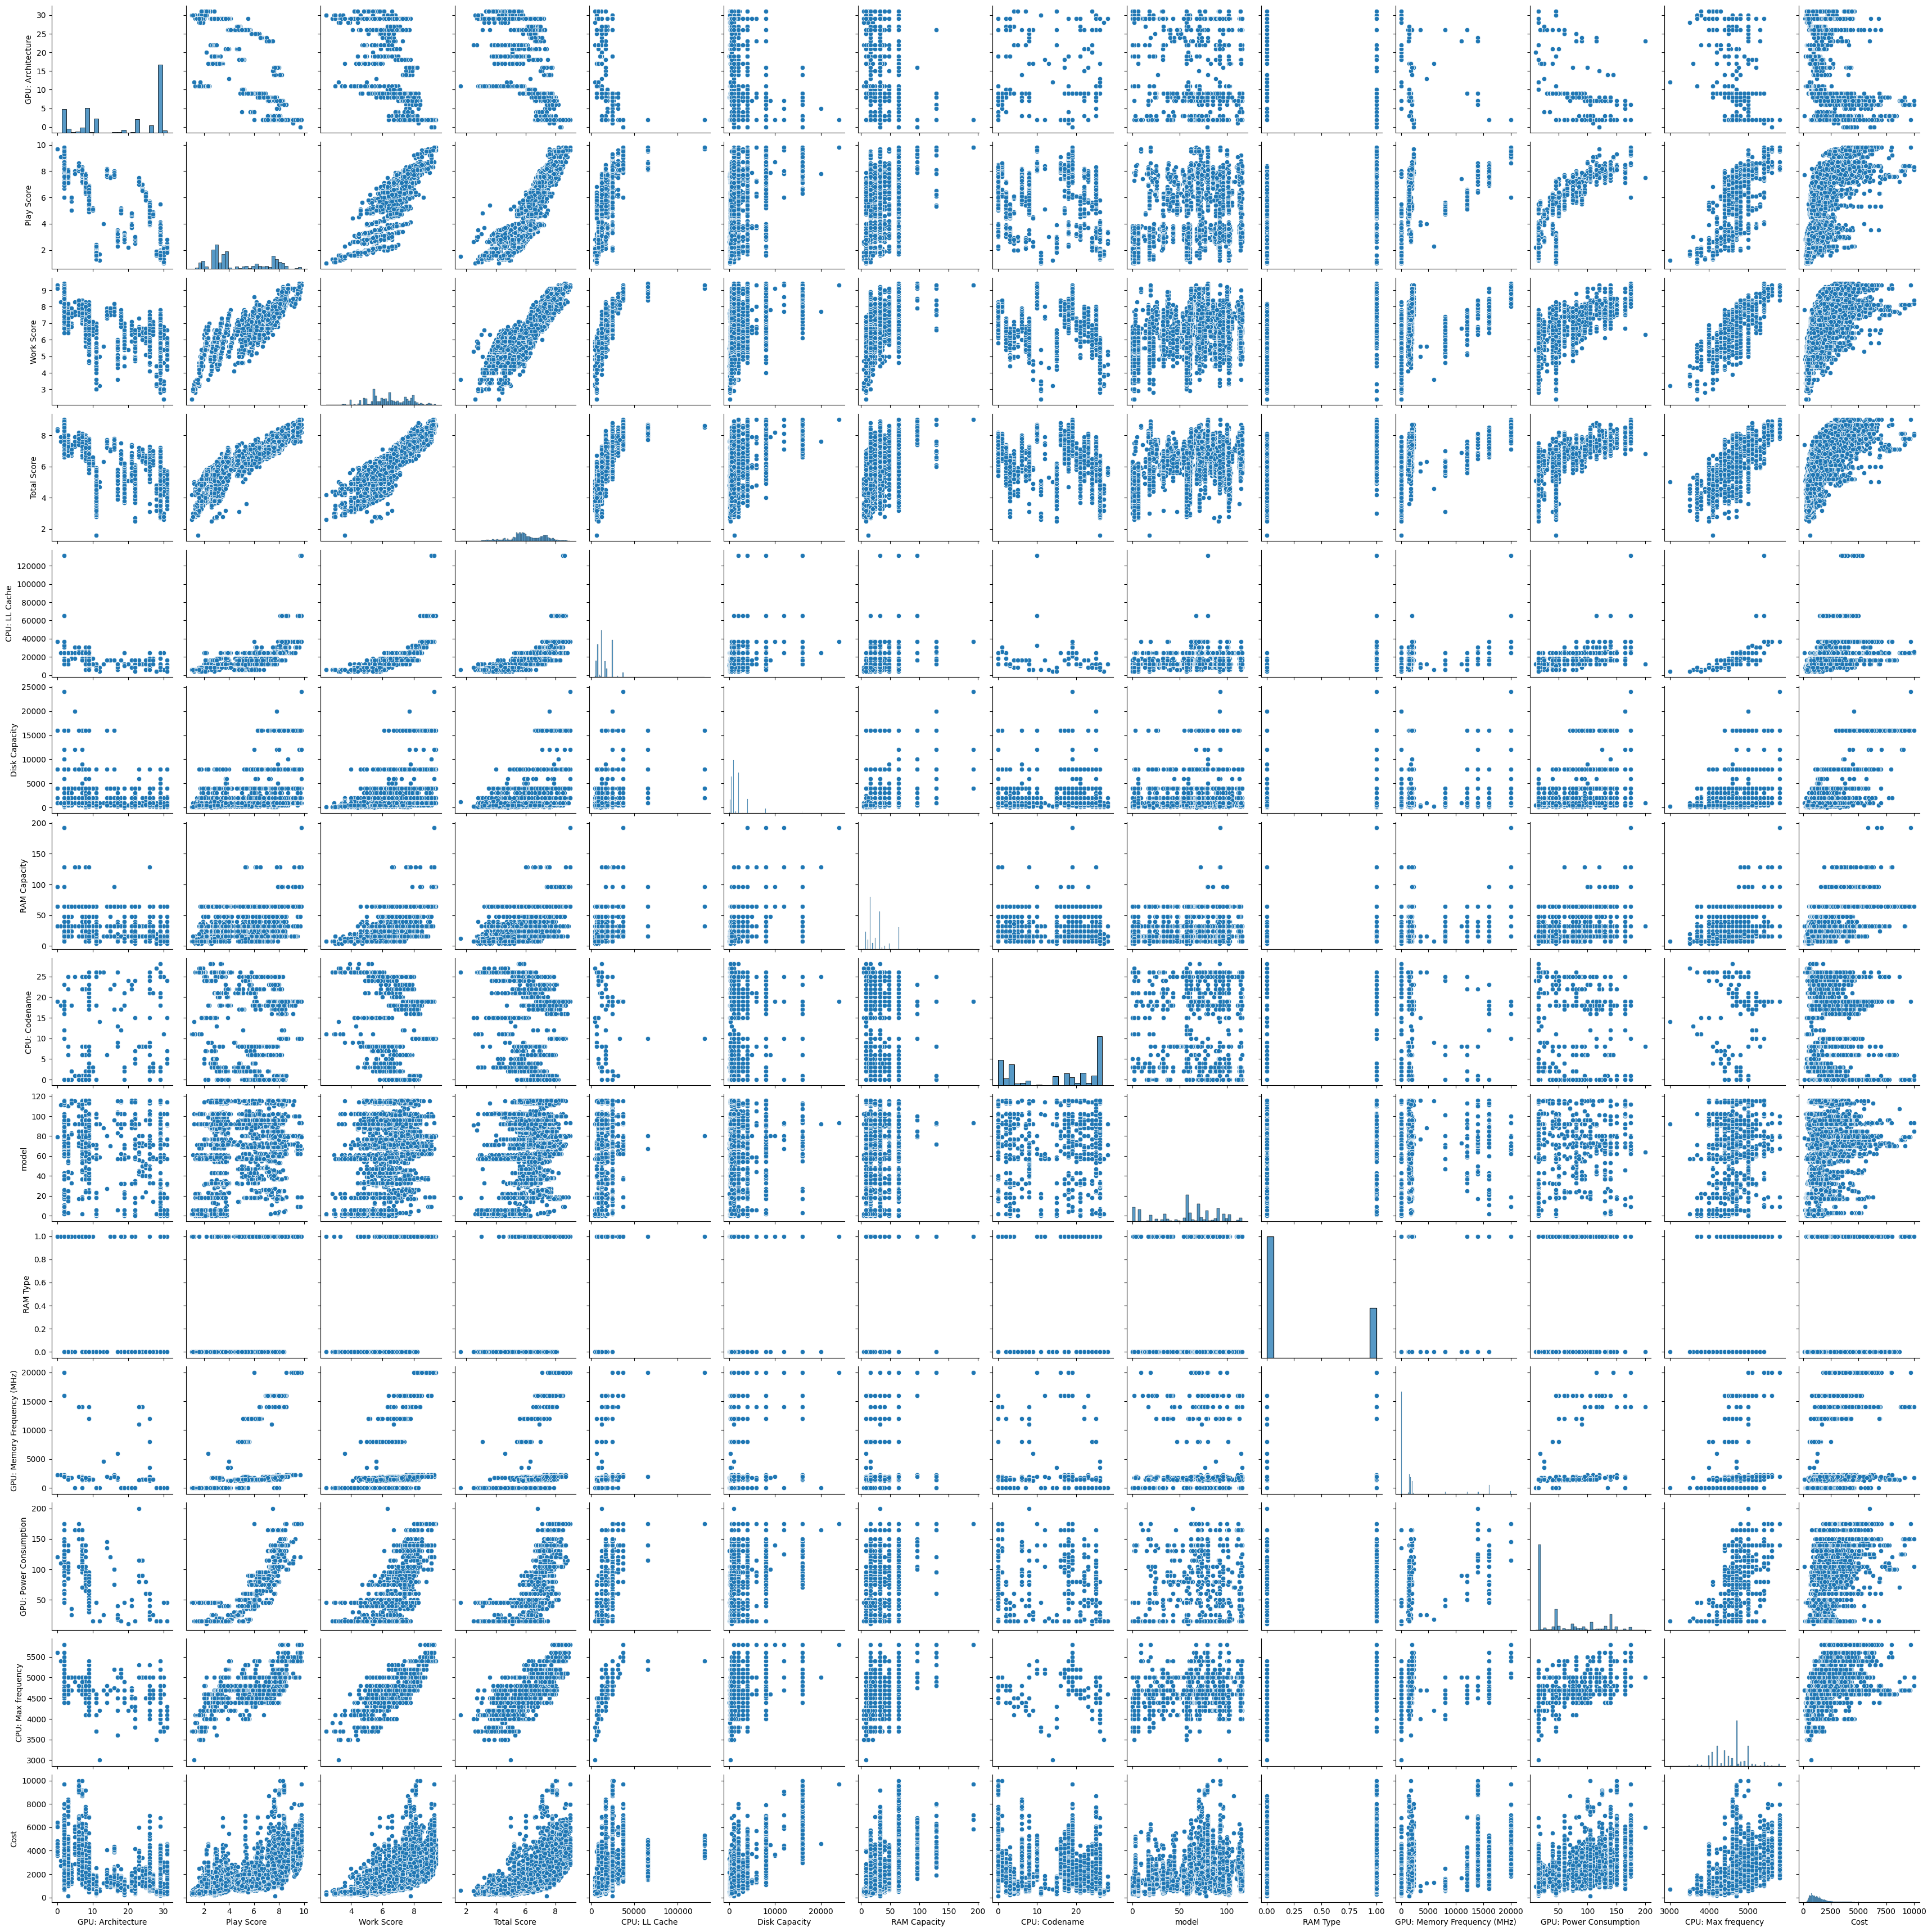

In [17]:
# visualize the relationship between features and cost                        
relationship = reduced_X_train[final_features].join(reduced_y_train)        
sns.pairplot(relationship)   

### Finetune Hyperparameter


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

* Model

In [18]:
model = {'K-Nearest Neighbors': KNeighborsRegressor(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regresion': SVR(),
    'Gradient Boosting' : GradientBoostingRegressor()}

* Grid Search

In [19]:
def grid_search(X, y,X_test, y_test, model , param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X, y)

    # result
    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X)
    print("Best parameters:", grid_search.best_params_)
    print("Best Score Train (MAE): ", mean_absolute_error(y_pred_train,y))
    print("Best Score Train (RMSE): ", np.sqrt(mean_squared_error(y_pred_train,y)))
    # evaluation
    print("\n --- Inference on Test Set ---")

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print('\n')


* Data Transform 

In [20]:
scaler = StandardScaler()
X_normalized_train = scaler.fit_transform(reduced_X_train[final_features])
X_normalized_test = scaler.transform(X_test[final_features])

In [21]:
y_train_final = reduced_y_train

* KNN 

In [255]:
param_grid_KNN = {
    'n_neighbors': [3,5,7,12,15,20,30, 40],        
    'weights': ['uniform', 'distance'],              
    'metric': ['euclidean', 'manhattan', 'minkowski']} 
grid_search(X_normalized_train,y_train_final,X_normalized_test, y_test, model['K-Nearest Neighbors'],param_grid_KNN)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best Score Train (MAE):  87.303026786668
Best Score Train (RMSE):  167.5921089100917

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 294.78424201728745
Mean Absolute Error (MAE): 152.41256465098346




* Ridge Regression

In [22]:
param_grid_ridge = {
    'alpha': [0.1,0.001, 0.2,1, 10, 20],
    'solver': ['auto', 'sag', 'lsqr'],
    'fit_intercept': [True, False],
}
grid_search(X_normalized_train,y_train_final,X_normalized_test, y_test, model['Ridge Regression'],param_grid_ridge)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'alpha': 0.001, 'fit_intercept': True, 'solver': 'sag'}
Best Score Train (MAE):  299.5683573217209
Best Score Train (RMSE):  474.44241690142263

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 480.82532206570073
Mean Absolute Error (MAE): 304.562335934396




* Random Forest Regression

In [256]:
param_grid_RF = {"n_estimators": [50, 100, 200],
                "max_depth": [None, 10, 20],
                 "min_samples_split": [2, 5, 10],
                 "max_features": ['sqrt', 'log2']}
grid_search(X_normalized_train,y_train_final,X_normalized_test, y_test, model['Random Forest'], param_grid_RF)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200}
Best Score Train (MAE):  105.90644013594589
Best Score Train (RMSE):  182.2533048225076

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 270.39180590621913
Mean Absolute Error (MAE): 145.25365753783046




* SVM

In [257]:
param_grid_svm = {
    'C': [ 10, 100, 120],             
    'epsilon': [0.1, 0.2, 0.3],     
    'kernel': ['rbf'],  
} 
grid_search(X_normalized_train, y_train_final,X_normalized_test, y_test, model['Support Vector Regresion'],param_grid_svm)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'C': 120, 'epsilon': 0.3, 'kernel': 'rbf'}
Best Score Train (MAE):  209.2358143976782
Best Score Train (RMSE):  377.11281590724667

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 394.63328328242926
Mean Absolute Error (MAE): 216.49854863811146




* Gradient boosting

In [260]:
param_grid_gradient = {
        'n_estimators': [50, 100 , 120 , 150, 160, 170],        
        'learning_rate': [0.03, 0.05],    
        'max_depth': [3, 5, 7, 8],                          
    }
grid_search(X_normalized_train, y_train_final,X_normalized_test, y_test, model['Gradient Boosting'],param_grid_gradient)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 170}
Best Score Train (MAE):  132.76523291485998
Best Score Train (RMSE):  209.36550893179876

 --- Inference on Test Set ---
Root Mean Squared Error (RMSE): 271.1643160168998
Mean Absolute Error (MAE): 153.17457739477427




### Inference 

In [23]:
df_inference =  X_test.join(df["link"]) 

In [24]:
df_inference

GPU: Architecture  Play Score  Work Score  Total Score  CPU: LL Cache  \
232654                  3         7.6         7.3          7.3        24576.0   
104307                 29         3.6         6.2          6.0        12288.0   
79328                  29         3.8         6.8          6.0        12288.0   
120781                 22         2.8         5.9          4.3         8192.0   
79927                  29         3.5         5.8          6.0        12288.0   
...                   ...         ...         ...          ...            ...   
106590                 29         3.7         6.6          5.9        12288.0   
111232                 29         3.2         6.3          5.9        12288.0   
282290                 29         1.6         4.0          3.1         6144.0   
129461                  3         7.1         6.4          6.7        12288.0   
63276                  27         4.8         6.7          6.2        16384.0   

        Disk Capacity  RAM Capacity  CPU: Codename  model  RAM Type  \
232654         8000.0          16.0             25     73         0   
104307         4000.0          16.0              3     57         0   
79328          4000.0          64.0             21     71         0   
120781         1000.0          24.0             15      0         0   
79927          1000.0          12.0             21      0         0   
...               ...           ...            ...    ...       ...   
106590         2000.0          48.0              3     59         0   
111232         2000.0          32.0              3     71         0   
282290          256.0           8.0             26     57         0   
129461         8000.0          16.0             25     96         0   
63276          1256.0          16.0              4     59         0   

        GPU: Memory Frequency (MHz)  GPU: Power Consumption  \
232654                       1500.0                   110.0   
104307                          0.0                    15.0   
79328                           0.0                    15.0   
120781                          0.0                    15.0   
79927                           0.0                    15.0   
...                             ...                     ...   
106590                          0.0                    15.0   
111232                          0.0                    15.0   
282290                          0.0                    15.0   
129461                       1500.0                    85.0   
63276                        1500.0                    25.0   

        CPU: Max frequency                                               link  
232654              4600.0  https://laptopmedia.com/laptop-specs/acer-pred...  
104307              4700.0  https://laptopmedia.com/laptop-specs/lenovo-id...  
79328               5000.0  https://laptopmedia.com/laptop-specs/hp-pavili...  
120781              4000.0   https://laptopmedia.com/laptop-specs/hp-14-7487/  
79927               5000.0   https://laptopmedia.com/laptop-specs/hp-14-5716/  
...                    ...                                                ...  
106590              4700.0  https://laptopmedia.com/laptop-specs/dell-insp...  
111232              4400.0  https://laptopmedia.com/laptop-specs/hp-pavili...  
282290              4100.0  https://laptopmedia.com/laptop-specs/lenovo-id...  
129461              4800.0  https://laptopmedia.com/laptop-specs/asus-tuf-...  
63276               4500.0  https://laptopmedia.com/laptop-specs/dell-insp...  

[7802 rows x 14 columns]

In [25]:
def predict(link_laptop):
    model_pred =  RandomForestRegressor(max_depth = 20, max_features = 'log2', min_samples_split = 2, n_estimators = 200)
    model_pred.fit(X_normalized_train,y_train)
    score = model_pred.predict(scaler.transform(df_inference[df_inference['link'] == link_laptop][final_features]))
    print(score)


In [30]:
result = predict(df_inference.loc[106590].link)
check = df_inference.join(y_test).loc[106590]['Cost']
print(check)

[1157.0184523]
1159.0
